
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [84]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re

df = pd.read_csv("https://raw.githubusercontent.com/ekoly/DS-Unit-2-Applied-Modeling/master/data/ufc/data.csv")

In [6]:
r_fighter_cols = [col for col in df.columns if col.startswith("R_")]
b_fighter_cols = [col for col in df.columns if col.startswith("B_")]

other_cols = [col for col in df.columns if col not in r_fighter_cols and col not in b_fighter_cols]

def extractFighters(df, fighter_cols, opp_cols, fighter_prefix, opp_prefix, fighter_color):

    fighters_df = df[fighter_cols + other_cols].copy()
    fighters_df.columns = [col.replace(fighter_prefix, "") for col in fighters_df.columns]
    fighters_df["is_winner"] = fighters_df["Winner"] == fighter_color

    opp_df = df[opp_cols].copy()
    opp_df.columns = [re.sub(r"^" + opp_prefix, "opponent_", col) for col in opp_df.columns]

    fighters_df = pd.concat([fighters_df, opp_df], axis=1)
    
    return fighters_df

r_fighters_df = extractFighters(df, r_fighter_cols, b_fighter_cols, "R_", "B_", "Red")
b_fighters_df = extractFighters(df, b_fighter_cols, r_fighter_cols, "B_", "R_", "Blue")

fighters_df = pd.concat([r_fighters_df, b_fighters_df], axis=0)

C:\Users\mrmcd\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [49]:
fighters_df['date'] = pd.to_datetime(fighters_df['date'])

In [127]:
fighters_df.isnull().sum()

Height_cms                     12
Reach_cms                     982
Referee                        46
Stance                        293
Weight_lbs                      9
                             ... 
win_by_Decision_Unanimous       0
win_by_KO/TKO                   0
win_by_Submission               0
win_by_TKO_Doctor_Stoppage      0
wins                            0
Length: 157, dtype: int64

In [107]:
fighters_df.set_index('date', inplace=True)
train = fighters_df.loc['2000-03-10':'2005-11-19']
test = fighters_df.loc['2008-01-19':'2009-12-12']
val = fighters_df.loc['2006-01-16':'2007-12-29']


In [72]:
pd.options.display.max_seq_items = None
pd.options.display.max_columns = None

In [115]:
target = 'is_winner'
features = ['Height_cms', 'Reach_cms','Stance', 'Weight_lbs',
       'Winner', 'age', 'avg_BODY_att', 'avg_BODY_landed', 'avg_CLINCH_att',
       'avg_CLINCH_landed', 'avg_DISTANCE_att', 'avg_DISTANCE_landed',
       'avg_GROUND_att', 'avg_GROUND_landed', 'avg_HEAD_att',
       'avg_HEAD_landed', 'avg_KD', 'avg_LEG_att', 'avg_LEG_landed',
       'avg_PASS', 'avg_REV', 'avg_SIG_STR_att', 'avg_SIG_STR_landed',
       'avg_SIG_STR_pct', 'avg_SIG_STatt', 'avg_SIG_STlanded', 'avg_SIG_STpct',
       'avg_SUATT', 'avg_SUB_ATT', 'avg_TD_att', 'avg_TD_landed', 'avg_TD_pct',
       'avg_TOTAL_STR_att', 'avg_TOTAL_STR_landed', 'avg_TOTAL_STatt',
       'avg_TOTAL_STlanded', 'avg_opp_BODY_att', 'avg_opp_BODY_landed',
       'avg_opp_CLINCH_att', 'avg_opp_CLINCH_landed', 'avg_opp_DISTANCE_att',
       'avg_opp_DISTANCE_landed', 'avg_opp_GROUND_att',
       'avg_opp_GROUND_landed', 'avg_opp_HEAD_att', 'avg_opp_HEAD_landed',
       'avg_opp_KD', 'avg_opp_LEG_att', 'avg_opp_LEG_landed', 'avg_opp_PASS',
       'avg_opp_REV', 'avg_opp_SIG_STR_att', 'avg_opp_SIG_STR_landed',
       'avg_opp_SIG_STR_pct', 'avg_opp_SIG_STatt', 'avg_opp_SIG_STlanded',
       'avg_opp_SIG_STpct', 'avg_opp_SUATT', 'avg_opp_SUB_ATT',
       'avg_opp_TD_att', 'avg_opp_TD_landed', 'avg_opp_TD_pct',
       'avg_opp_TOTAL_STR_att', 'avg_opp_TOTAL_STR_landed',
       'avg_opp_TOTAL_STatt', 'avg_opp_TOTAL_STlanded', 'current_lose_streak',
       'current_win_streak', 'draw', 'fighter','location',
       'longest_win_streak', 'losses', 'no_of_rounds', 'opponent_Height_cms',
       'opponent_Reach_cms', 'opponent_Stance', 'opponent_Weight_lbs',
       'opponent_age', 'opponent_avg_BODY_att', 'opponent_avg_BODY_landed',
       'opponent_avg_CLINCH_att', 'opponent_avg_CLINCH_landed',
       'opponent_avg_DISTANCE_att', 'opponent_avg_DISTANCE_landed',
       'opponent_avg_GROUND_att', 'opponent_avg_GROUND_landed',
       'opponent_avg_HEAD_att', 'opponent_avg_HEAD_landed', 'opponent_avg_KD',
       'opponent_avg_LEG_att', 'opponent_avg_LEG_landed', 'opponent_avg_PASS',
       'opponent_avg_REV', 'opponent_avg_SIG_STR_att',
       'opponent_avg_SIG_STR_landed', 'opponent_avg_SIG_STR_pct',
       'opponent_avg_SUB_ATT', 'opponent_avg_TD_att', 'opponent_avg_TD_landed',
       'opponent_avg_TD_pct', 'opponent_avg_TOTAL_STR_att',
       'opponent_avg_TOTAL_STR_landed', 'opponent_avg_opp_BODY_att',
       'opponent_avg_opp_BODY_landed', 'opponent_avg_opp_CLINCH_att',
       'opponent_avg_opp_CLINCH_landed', 'opponent_avg_opp_DISTANCE_att',
       'opponent_avg_opp_DISTANCE_landed', 'opponent_avg_opp_GROUND_att',
       'opponent_avg_opp_GROUND_landed', 'opponent_avg_opp_HEAD_att',
       'opponent_avg_opp_HEAD_landed', 'opponent_avg_opp_KD',
       'opponent_avg_opp_LEG_att', 'opponent_avg_opp_LEG_landed',
       'opponent_avg_opp_PASS', 'opponent_avg_opp_REV',
       'opponent_avg_opp_SIG_STR_att', 'opponent_avg_opp_SIG_STR_landed',
       'opponent_avg_opp_SIG_STR_pct', 'opponent_avg_opp_SUB_ATT',
       'opponent_avg_opp_TD_att', 'opponent_avg_opp_TD_landed',
       'opponent_avg_opp_TD_pct', 'opponent_avg_opp_TOTAL_STR_att',
       'opponent_avg_opp_TOTAL_STR_landed', 'opponent_current_lose_streak',
       'opponent_current_win_streak', 'opponent_draw', 'opponent_fighter',
       'opponent_longest_win_streak', 'opponent_losses',
       'opponent_total_rounds_fought', 'opponent_total_time_fought(seconds)',
       'opponent_total_title_bouts', 'opponent_win_by_Decision_Majority',
       'opponent_win_by_Decision_Split', 'opponent_win_by_Decision_Unanimous',
       'opponent_win_by_KO/TKO', 'opponent_win_by_Submission',
       'opponent_win_by_TKO_Doctor_Stoppage', 'opponent_wins', 'title_bout',
       'total_rounds_fought', 'total_time_fought(seconds)',
       'total_title_bouts', 'weight_class', 'win_by_Decision_Majority',
       'win_by_Decision_Split', 'win_by_Decision_Unanimous', 'win_by_KO/TKO',
       'win_by_Submission', 'win_by_TKO_Doctor_Stoppage', 'wins']

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

In [128]:
target = 'wins'
features = ['Height_cms', 'win_by_Submission','Weight_lbs','win_by_KO/TKO','opponent_losses']

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

In [110]:
X_val.shape

(658, 6)

In [129]:

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.8161942202814823


In [130]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Weight_lbs'

isolated = pdp_isolate(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    num_grid_points=50,
    feature=feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x23765d34d08>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x23765a73ac8>})

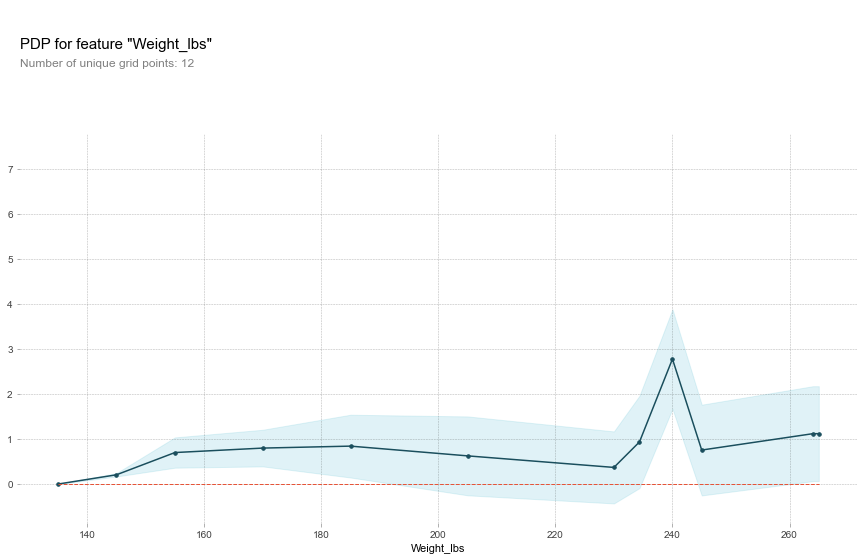

In [113]:
pdp_plot(isolated, feature_name=feature)

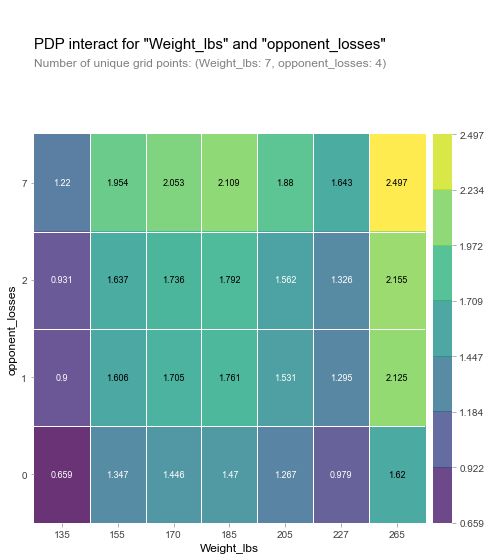

In [122]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Weight_lbs','opponent_losses']

interaction = pdp_interact(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

# pdp_interact_plot(interaction, plot_type='grid', feature_names=features);
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [131]:
X_train.isnull().sum()

Height_cms           0
win_by_Submission    0
Weight_lbs           0
win_by_KO/TKO        0
opponent_losses      0
dtype: int64

In [132]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.9s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished


In [133]:
model = search.best_estimator_

In [134]:
row = X_test.iloc[[0]]

In [135]:
y_test.iloc[[0]]

date
2009-12-12    10.0
Name: wins, dtype: float64

In [136]:
model.predict(row)

array([8.46637053])

In [137]:
# Why did the model predict this?
# Look at a Shapley Values Force Plot

import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)